In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import math
import tqdm as tqdm
import AdamW as adamw
import SGDW as sgdw
import CLR as CLR
import lr_scheduler as lr_scheduler

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
np.random.seed(42)

# Load Dataset

In [5]:
mean = [0.491, 0.482, 0.447]
std = [0.247, 0.243, 0.262]

In [6]:
normalize = transforms.Normalize(mean=mean, std=std)
train_transforms = transforms.Compose([
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomResizedCrop(32),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize
                ])

In [7]:
trainset = CIFAR10('./data', train=True, download=True, transform=train_transforms)
testset = CIFAR10('./data', train=False, download=True, transform=train_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
bs=64
epoch=10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)

# Plot Images

In [10]:
# Plot few of the images
# This can be used to print predictions too
def plot_img(preds=None, is_pred=False):        
    fig = plt.figure(figsize=(8,8));
    columns = 4;
    rows = 5;

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred:
            img_xy = np.random.randint(len(testset));
            img = testset[img_xy][0].numpy()
            #img = img * std + mean
        else:
            img_xy = np.random.randint(len(trainset));
            img = trainset[img_xy][0].numpy()
            #img = img * std + mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img , (1,2,0)), interpolation='nearest')
    plt.show()

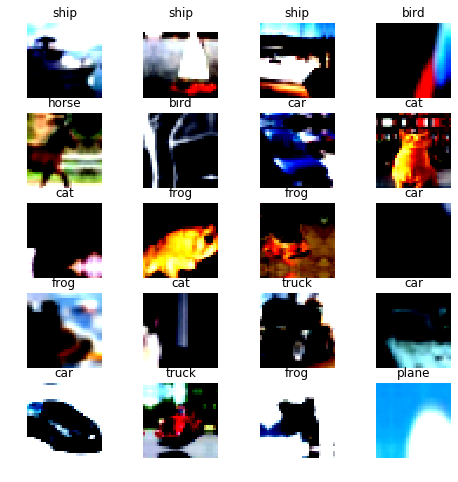

In [11]:
plot_img()

# save and load checkpoint

In [12]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [13]:
def load_checkpoint(model, filename = 'data/checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

# Global Variables

In [14]:
train_loss = 0.0
test_loss = 0.0
best_acc = 0.0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

In [15]:
total = 0
correct = 0

# Helper Functions

In [16]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = target.size(0)
    total += batch_size    
    _, pred = output.max(dim=1)
    if is_test:
        preds.extend(pred)
    correct += torch.sum(pred == target.data)
    return (correct.float() / total) * 100

In [17]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [18]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [19]:
def reset():
    global total, correct
    global train_loss, test_loss, best_acc
    global trn_accs, trn_losses, val_accs, val_losses
    total, correct = 0, 0
    train_loss, test_loss, best_acc = 0.0, 0.0, 0.0
    trn_losses, trn_accs, val_accs, val_losses = [], [], [], []

In [20]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [21]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.adavgp = nn.AdaptiveAvgPool2d(sz)
        self.adamaxp = nn.AdaptiveMaxPool2d(sz)
        
    def forward(self, x):
        x = torch.cat([self.adavgp(x), self.adamaxp(x)], 1)
        x = x.view(x.size(0),-1)
        return x

# CLR

In [35]:
def lr_find(clr, model):
    t = tqdm.tqdm(train_loader, leave=False, total=len(train_loader))
    running_loss = 0.
    avg_beta = 0.98
    model.train()
    for i, (input, target) in enumerate(t):
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
        output = model(var_ip)
        loss = criterion(output, var_tg)
    
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)
    
        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(optimizer, lr)   
    
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Train and Test

In [40]:
def train(epoch=0, model=model, sched=None):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98
    if sched != None:
        sched.step()
    for i, (input, target) in enumerate(train_loader):
        bt_start = time.time()
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
                            
        output = model(var_ip)
        loss = criterion(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [41]:
def test(model=model):
    with torch.no_grad():
        model.eval()
        global val_accs, val_losses
        running_loss = 0.
        avg_beta = 0.98
        for i, (input, target) in enumerate(test_loader):
            bt_start = time.time()
            input, target = input.to(device), target.to(device)
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = criterion(output, var_tg)
        
            running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss.item(), prec, time.time()-bt_start)
        
            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [42]:
def fit(model=model):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    for j in range(epoch):
        train(j, model)
        test(model)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

# Model

In [43]:
model = models.resnet50(pretrained=True)

In [44]:
model.avgpool = AdaptiveConcatPool2d()
model.fc = nn.Linear(in_features=model.fc.in_features * 2 , out_features=10, bias=True)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [45]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True

In [46]:
criterion = nn.CrossEntropyLoss()

In [47]:
optimizer = adamw.AdamW(model.fc.parameters(), lr=0.001, weight_decay=1e-4)

In [48]:
preds = []
epoch = 10
train_stats = AvgStats()
test_stats = AvgStats()

In [49]:
fit(model)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.83852239	1.82624330	36.81999969	37.42166901
2	1.80950711	1.94187427	38.70817947	38.82583237
3	1.75793590	1.76958685	39.41705704	39.63833618
4	1.76242793	1.71515836	40.04043579	40.17958450
5	1.77034186	1.72043780	40.45448303	40.50600052
6	1.74537935	1.76313695	40.72399902	40.76861191
7	1.76456467	1.88353879	40.90927124	40.91428375
8	1.76507961	1.78163549	40.99021149	41.03291702
9	1.74043799	1.70465562	41.12962341	41.19833374
10	1.76470655	1.81118069	41.26356125	41.27983475
